<a href="https://colab.research.google.com/github/agtushar/aml-robust-learning/blob/main/ADV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import json
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# CONFIG

In [ ]:
root_dir = "/content/drive/Shareddrives/advattacks"
###### MODEL CONFIGURATION #####
model_dir= os.path.join(root_dir,"models")

###### TRAINING CONFIGURATION #####
random_seed= 4557077
max_num_training_steps= 100000
num_output_steps= 100
num_summary_steps= 100
num_checkpoint_steps= 300
training_batch_size= 50

###### EVAL CONFIGURATION #####
num_eval_examples= 10000
eval_batch_size= 200

###### ADVERSARIAL EXAMPLES CONFIGURATION#####
epsilon= 0.3
iters= 4
alpha= 0.01
random_start= True
loss_func= "xent"
store_adv_path= "attack.npy"

# PREPARE DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_set  = datasets.MNIST(root_dir,train=True,transform=torchvision.transforms.ToTensor(),download=True)
eval_set  = datasets.MNIST(root_dir,train=False,transform=torchvision.transforms.ToTensor(),download=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=training_batch_size, shuffle=True)
eval_dl = torch.utils.data.DataLoader(eval_set, batch_size=eval_batch_size)

len(train_set), len(eval_set)

(60000, 10000)

# MODEL

In [ ]:
class CONVNET(torch.nn.Module):
    def __init__(self):
        super(CONVNET, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5,5),bias=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5,5),bias=True)
        self.full1 =  nn.Linear(64 * 4 * 4, 1024, bias = True)
        self.full2 =  nn.Linear(1024, 10, bias = True)

    
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = (2,2))
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = (2,2))
        x = x.reshape(x.shape[0],-1)
        x = self.full1(x)
        x = self.full2(x)
        x = F.log_softmax(x, dim=1)
        return x


x = torch.rand(64, 1, 28 , 28)
examplenet = CONVNET()
examplenet(x).shape

torch.Size([64, 10])

GENERATOR (ADV-GAN)

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out
        
class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            # MNIST:1*28*28
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 28 x 28
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x

# ADVERSARY

In [ ]:
def pgd_attack(model, images, labels, eps=epsilon, alpha=alpha, iters=iters):
    
    imagescopy = images.clone().detach()
    imagescopy = imagescopy.to(device)
    labels = labels.to(device)

    adv_samples = []
    for i in range(iters):    
        imagescopy.requires_grad = True
        outputs = model(imagescopy)
        model.zero_grad()
        cost = criterion(outputs, labels).to(device)
        cost.backward()
        
        
        adv_images = imagescopy + alpha*imagescopy.grad.sign()
        eta = torch.clamp(adv_images - images, min=-eps, max=eps)
        imagescopy = torch.clamp(images + eta, min=0, max=1).detach_()
        imagescopy.requires_grad = False
        adv_samples.append(imagescopy.clone().detach())
    
    return adv_samples

In [ ]:
def advGAN_attack(images, eps=epsilon):
    #load the pretrained generator
    generator_path = os.path.join(model_dir,'ADVGAN_netG_epoch_60.pth') 
    netG = torch.load(generator_path)
    netG.eval()
    out = []
    for i in range(iters):
      perturbation = netG(images)
      perturbation = torch.clamp(perturbation, -eps, eps)
      adv_images = perturbation + images
      adv_images = torch.clamp(adv_images, 0, 1)
      out.append(adv_images)
    return out

# TRAINING

In [ ]:
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = False

LEARNING_RATE = 1e-4

## model to be trained using natural/trivial training
nat_net = CONVNET()
nat_net = nat_net.to(device)

pgd_net = CONVNET()
pgd_net = pgd_net.to(device)

gan_net = CONVNET()
gan_net = gan_net.to(device)

## model to be trained using adversial learning
adv_net = CONVNET()
adv_net = adv_net.to(device)

# CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()

# Adam optimizer
nat_optimizer = torch.optim.Adam(nat_net.parameters(), lr=LEARNING_RATE)
pgd_optimizer = torch.optim.Adam(pgd_net.parameters(), lr=LEARNING_RATE)
gan_optimizer = torch.optim.Adam(gan_net.parameters(), lr=LEARNING_RATE)
adv_optimizer = torch.optim.Adam(adv_net.parameters(), lr=LEARNING_RATE)

# MODEL PATH
pgd_modelpath = os.path.join(model_dir, "pgd-res.pth")
gan_modelpath = os.path.join(model_dir, "advgan-res.pth")
adv_modelpath = os.path.join(model_dir, "advgan_pgd-res.pth")
nat_modelpath = os.path.join(model_dir, "nat.pth")

In [ ]:
from tqdm.notebook import tqdm

def train(model,optimizer,isadversary=0):
    epoch_loss = 0
    epoch_accuracy = 0

    for (data, digits) in tqdm(train_dl):
        data = data.to(device)
        digits = digits.to(device)
        data_list = [data]

        if isadversary == 1 or isadversary == 3:
            adv_images = pgd_attack(model, data, digits)
            data_list = data_list + adv_images
        if isadversary == 2 or isadversary == 3:
            adv_images = advGAN_attack(data)
            data_list = data_list + adv_images
        for data in data_list:
            output = model(data)
            loss = criterion(output, digits)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                e_loss = loss.item()
                e_acc = (output.max(1)[1] == digits).sum().item()
            epoch_loss += e_loss/len(data_list)
            epoch_accuracy += e_acc/len(data_list)

    return epoch_loss/len(train_set), epoch_accuracy/len(train_set)

In [ ]:
load_pretrained = False

if (load_pretrained):
    nat_net = torch.load(nat_modelpath)
    adv_net = torch.load(adv_modelpath)
    pgd_net = torch.load(pgd_modelpath)
    gan_net = torch.load(gan_modelpath)
else:
    ## NUMBER OF EPOCHS TO TRAIN
    N_EPOCHS = 3

    ## Put the network in training mode
    nat_net.train()
    adv_net.train()
    pgd_net.train()
    gan_net.train()

    for e in range(N_EPOCHS):
        print("EPOCH:",e+1)
        print("Natural Model:")
        e_loss, e_acc = train(nat_net,nat_optimizer)
        print("Training accuracy: {:.6f} Training loss: {:.6f}".format(e_acc,e_loss))

        print("EPOCH:",e+1)
        print("PGD Model:")
        e_loss, e_acc = train(pgd_net,pgd_optimizer,isadversary=1)
        print("Training accuracy: {:.6f} Training loss: {:.6f}".format(e_acc,e_loss))

        print("EPOCH:",e+1)
        print("GAN Model:")
        e_loss, e_acc = train(gan_net,gan_optimizer,isadversary=2)
        print("Training accuracy: {:.6f} Training loss: {:.6f}".format(e_acc,e_loss))

        print("Robust Model:")
        e_loss, e_acc = train(adv_net, adv_optimizer, isadversary=3)
        print("Training accuracy: {:.6f} Training loss: {:.6f}".format(e_acc,e_loss))
        print()

EPOCH: 1
Natural Model:



Training accuracy: 0.918133 Training loss: 0.005889
EPOCH: 1
PGD Model:



Training accuracy: 0.950653 Training loss: 0.003108
EPOCH: 1
GAN Model:



Training accuracy: 0.946157 Training loss: 0.003579
Robust Model:



Training accuracy: 0.958604 Training loss: 0.002728

EPOCH: 2
Natural Model:



Training accuracy: 0.974767 Training loss: 0.001668
EPOCH: 2
PGD Model:



Training accuracy: 0.980070 Training loss: 0.001211
EPOCH: 2
GAN Model:



Training accuracy: 0.986347 Training loss: 0.000910
Robust Model:



Training accuracy: 0.986126 Training loss: 0.000945

EPOCH: 3
Natural Model:



Training accuracy: 0.981150 Training loss: 0.001207
EPOCH: 3
PGD Model:



Training accuracy: 0.985160 Training loss: 0.000881
EPOCH: 3
GAN Model:



Training accuracy: 0.991243 Training loss: 0.000590
Robust Model:



Training accuracy: 0.989631 Training loss: 0.000669



ATTACK DEMO

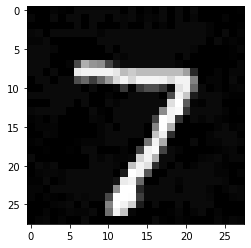

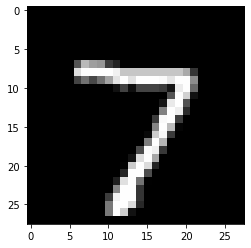

distance:  tensor(0.8044)
tensor(7, device='cuda:0')
tensor(7, device='cuda:0')


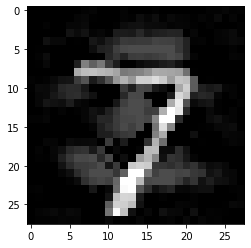

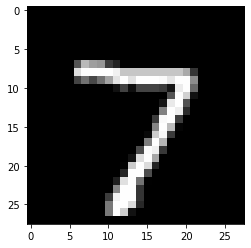

distance:  tensor(3.3648)
tensor(7, device='cuda:0')
tensor(3, device='cuda:0')


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

nat_net.eval()
adv_net.eval()

def adv_demo(data,digits, adv="PGD"):   
    if (adv=="PGD"):
        adv_samples = pgd_attack(nat_net,data,digits)
    elif (adv=="ADVGAN") :
        adv_samples = advGAN_attack(data)
    adv_predictions = adv_net(adv_samples[0])
    data = data.to(device)
    nat_predictions = nat_net(adv_samples[0])

    adv_image = adv_samples[-1][0][0].cpu().detach()
    orig_image = data[0][0].cpu().detach()

    plt.imshow(adv_image, cmap='gray')
    plt.show()
    plt.imshow(orig_image, cmap='gray')
    plt.show()

    print("distance: ", torch.dist(adv_image, orig_image, p=2))
    print(adv_predictions.max(1)[1][0])
    print(nat_predictions.max(1)[1][0])

data, digits = next(iter(eval_dl))
data = data.to(device)
digits = digits.to(device)

adv_demo(data,digits,"PGD")
adv_demo(data,digits,"ADVGAN")

# EVALUATION

In [ ]:
def eval(model,isadversary=False):

    epoch_loss = 0
    epoch_accuracy = 0

    for (data, digits) in tqdm(eval_dl):
        digits = digits.to(device)
        data = data.to(device)
        data_list = [data]
        if (isadversary):
            adv_images = pgd_attack(model,data,digits)
            adv_images = adv_images + advGAN_attack(data)
            data_list = data_list + adv_images
        
        for data in data_list:
            output = model(data)
            loss = criterion(output, digits)
            
            with torch.no_grad():
                epoch_loss += loss.item()/len(data_list)
                epoch_accuracy += (output.max(1)[1] == digits).sum().item()/len(data_list)
    
    epoch_accuracy = epoch_accuracy/len(eval_set)
    epoch_loss = epoch_loss/len(eval_set)
    print("Eval accuracy: {:.6f} Eval loss: {:.6f}".format(epoch_accuracy,epoch_loss))
    return epoch_loss, epoch_accuracy

In [ ]:
running_loss = 0
running_accuracy = 0
## Put the network in eval model
nat_net.eval()
print("NATURAL MODEL: ")
e_loss, e_acc = eval(nat_net)
print(" on adversary eval data:")
e_loss, e_acc = eval(nat_net,isadversary=True)

pgd_net.eval()
print("PGD MODEL: ")
e_loss, e_acc = eval(pgd_net)
print(" on adversary eval data:")
e_loss, e_acc = eval(pgd_net,isadversary=True)

gan_net.eval()
print("GAN MODEL: ")
e_loss, e_acc = eval(gan_net)
print(" on adversary eval data:")
e_loss, e_acc = eval(gan_net,isadversary=True)

adv_net.eval()
print("ADVERSARIAL ROBUST MODEL: ")
e_loss, e_acc = eval(adv_net)
print(" on adversary eval data:")
e_loss, e_acc = eval(adv_net,isadversary=True)

NATURAL MODEL: 



Eval accuracy: 0.983200 Eval loss: 0.000250
 on adversary eval data:



Eval accuracy: 0.548844 Eval loss: 0.007390
PGD MODEL: 



Eval accuracy: 0.991100 Eval loss: 0.000122
 on adversary eval data:



Eval accuracy: 0.921211 Eval loss: 0.001098
GAN MODEL: 



Eval accuracy: 0.985500 Eval loss: 0.000261
 on adversary eval data:



Eval accuracy: 0.968522 Eval loss: 0.000559
ADVERSARIAL ROBUST MODEL: 



Eval accuracy: 0.991400 Eval loss: 0.000159
 on adversary eval data:



Eval accuracy: 0.984378 Eval loss: 0.000283


SAVE MODEL

In [ ]:
adv_modelpath = os.path.join(model_dir, "advgan_pgd-res.pth")
nat_modelpath = os.path.join(model_dir, "nat.pth")
torch.save(adv_net,adv_modelpath)
torch.save(nat_net,nat_modelpath)